# 0. Imports

In [1]:
import os
import csv

import numpy as np
import pandas as pd
from datetime import date


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
#from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Product
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C 

from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

# 1. Loading and preprocessing dataset

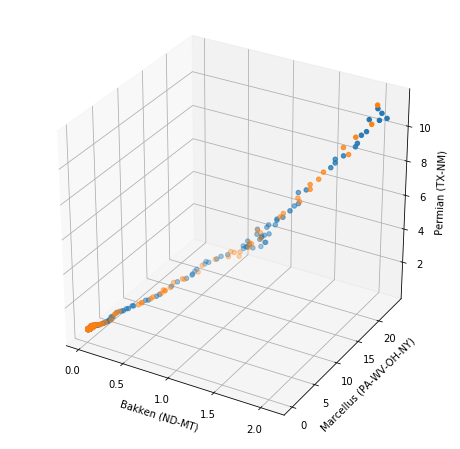

In [18]:
#renommer les colonnes portant le même nom que d'autres
def mangle_dupe_cols(columns):
    counts = {}
    for i, col in enumerate(columns):
        cur_count = counts.get(col, 0)
        if cur_count > 0:
            columns[i] = '%s.%d' % (col, cur_count)
        counts[col] = cur_count + 1
    return columns


def load_data():
    datapath = os.path.join('../dataset', fileName+'_data.csv')
    headerpath = os.path.join('../dataset', fileName+'_header.csv')
    
    data = list(csv.reader(open(datapath), delimiter=csvDelimiter)) 
    datanp = np.asarray(data).astype(np.float)
 
    header = list(csv.reader(open(headerpath), delimiter=csvDelimiter))
    header = header[0]
    datapd = pd.DataFrame(data, columns=mangle_dupe_cols(header))
    return datanp, datapd, header

#Choosing file to load :
fileName = 'shalegas' #shalegas, MLO2, noisysine
csvDelimiter = ','

datanp, datapd, headers = load_data()
data = datapd

#Splitting train/test :
ratioTrainTest = 0.6

x_train,x_test=train_test_split(data,train_size=ratioTrainTest,\
                                test_size=(1-ratioTrainTest),\
                                random_state=int(np.random.rand()*0))

if fileName == 'MLO2' or fileName == 'MLO':
    x_col = ['decimalDate']
    y_col = ['interpolated']
elif fileName == 'noisySine':
    x_col = ['x']
    y_col  = ['y']
elif fileName == 'shalegas':
    #x_col = ['Permian (TX-NM)','Marcellus (PA-WV-OH-NY)']
    #x_col = ['Marcellus (PA-WV-OH-NY)']
    #x_col = ['Bakken (ND-MT)','Marcellus (PA-WV-OH-NY)']
    x_col = ['Bakken (ND-MT)', 'Marcellus (PA-WV-OH-NY)']
    #y_col = ['Utica (OH-PA-WV)']
    y_col  = ['Permian (TX-NM)']

x_tr = x_train.loc[:,x_col].astype(float)
y_tr = x_train.loc[:,y_col].astype(float)
x_te = x_test.loc[:,x_col].astype(float)
y_te = x_test.loc[:,y_col].astype(float)

#Displaying the chosen dimensions :
if (np.size(x_col) == 1) :
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(x_tr[x_col[0]], y_tr, label='train')
    ax.scatter(x_te[x_col[0]], y_te, label='test')
    ax.set_xlabel(x_col[0])
    ax.set_ylabel(y_col[0])
    plt.show()



if (np.size(x_col) == 2) :
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_tr[x_col[0]], x_tr[x_col[1]], y_tr, label='train')
    ax.scatter(x_te[x_col[0]], x_te[x_col[1]], y_te, label='test')

    ax.set_xlabel(x_col[0])
    ax.set_ylabel(x_col[1])
    ax.set_zlabel(y_col[0])

    plt.show()

# 2. GPR

In [19]:
#Hyperparameters :
kernel_w = 1
gpr_kernel = RBF(float(kernel_w))
noise = 0.01

#Model :
gp = GaussianProcessRegressor(kernel=gpr_kernel, alpha=noise, optimizer=None, n_restarts_optimizer=0, \
                              normalize_y=True)

X = np.atleast_2d(x_tr)
y = np.atleast_2d(y_tr).T.ravel()

# Mesh the input space for evaluations of the real function, the prediction and its MSE
for i in range(X.shape[1]):
    if i == 0:
        x_grid = np.atleast_2d(np.linspace(int(np.min(X[:,i])-5), int(np.max(X[:,i])+5), 1000)).T
    else:
        x_grid = np.hstack((x_grid, np.transpose(np.atleast_2d(np.linspace(int(np.min(X[:,i])-5), \
                                                                           int(np.max(X[:,i])+5), 1000)))))

gp.fit(X, y)

#Predictions :
y_pred, std = gp.predict(x_grid, return_std=True)


if (np.size(x_col) == 1) :
    plt.figure(figsize=(8, 8))
    plt.plot(X, y, 'r.', markersize=10, label='Observations')
    plt.plot(x_grid, y_pred, 'b-', label='Prediction', lw = 0.5)
    plt.plot(x_te, y_te, 'g.', label="Test set")
    
    plt.fill(np.concatenate([x_grid, x_grid[::-1]]),
             np.concatenate([y_pred - 1.9600 * std,
                            (y_pred + 1.9600 * std)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel(x_col[0])
    plt.ylabel(y_col[0])
    plt.legend(loc='upper left')

In [8]:
x_grid

array([[-4.        , -5.        ],
       [-3.98898899, -4.96696697],
       [-3.97797798, -4.93393393],
       ...,
       [ 6.97797798, 27.93393393],
       [ 6.98898899, 27.96696697],
       [ 7.        , 28.        ]])

## GMR

In [20]:
#hyperparametres
#type_of_cov = 'full'
nb_components = 2

X = np.column_stack((np.array(x_tr),np.array(y_tr)))
x = np.array(x_tr)

# Mesh the input space for evaluations of the real function, the prediction and its MSE
x_grid = np.atleast_2d(np.linspace(int(np.min(X[:,i])-2), int(np.max(X[:,i])+1), 1000)).T
x_grid = np.transpose(x_grid).ravel()

gmm = GMM(n_components=nb_components, random_state=0)
gmm.from_samples(X)
y_pred = gmm.predict(np.array([0]), x_grid[:, np.newaxis])

if (np.size(x_col) == 1) :
    plt.figure(figsize=(8, 8))
    plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
              "\mathcal{N}_{k, Y|X}$")
    plt.scatter(X[:, 0], X[:, 1])
    plt.plot(x_grid, y_pred, c="k", lw=0.5)
    plot_error_ellipses(plt.gca(), gmm, 'r')

    plt.show()

C:\Users\123mn\Anaconda3\lib\site-packages\gmr\gmm.py:216: RuntimeWarning: invalid value encountered in true_divide
  priors /= priors.sum()


In [21]:
x_grid


array([-2.00000000e+00, -1.97397397e+00, -1.94794795e+00, -1.92192192e+00,
       -1.89589590e+00, -1.86986987e+00, -1.84384384e+00, -1.81781782e+00,
       -1.79179179e+00, -1.76576577e+00, -1.73973974e+00, -1.71371371e+00,
       -1.68768769e+00, -1.66166166e+00, -1.63563564e+00, -1.60960961e+00,
       -1.58358358e+00, -1.55755756e+00, -1.53153153e+00, -1.50550551e+00,
       -1.47947948e+00, -1.45345345e+00, -1.42742743e+00, -1.40140140e+00,
       -1.37537538e+00, -1.34934935e+00, -1.32332332e+00, -1.29729730e+00,
       -1.27127127e+00, -1.24524525e+00, -1.21921922e+00, -1.19319319e+00,
       -1.16716717e+00, -1.14114114e+00, -1.11511512e+00, -1.08908909e+00,
       -1.06306306e+00, -1.03703704e+00, -1.01101101e+00, -9.84984985e-01,
       -9.58958959e-01, -9.32932933e-01, -9.06906907e-01, -8.80880881e-01,
       -8.54854855e-01, -8.28828829e-01, -8.02802803e-01, -7.76776777e-01,
       -7.50750751e-01, -7.24724725e-01, -6.98698699e-01, -6.72672673e-01,
       -6.46646647e-01, -